# Project Phase 2

## CSE587 Data Intensive Computing

Hypothesis 1: Relationship between Data Science Team Size and Salary

Goal: Determine if companies with larger data science teams offer higher salaries.

Algorithms:
XGBoost Regression: Suitable for predicting normalized salary based on team size and other features.
Logistic Regression: Transform normalized salary into high/low categories to analyze team size’s impact on high salary odds.


Hypothesis 2: Impact of Remote Work on Job Popularity

Goal: Examine if remote job listings receive more views or applications.

Algorithm:


XGBoost Classifier: Analyze features influencing views or applications to see if remote jobs are more popular.


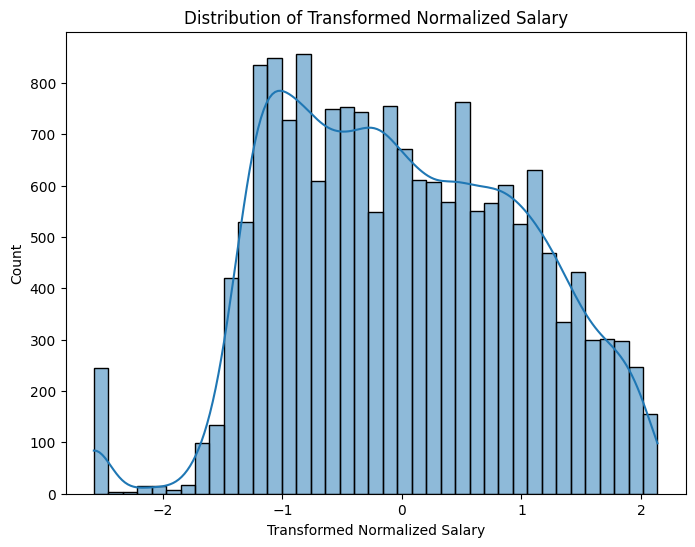

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 0.5, 'reg_lambda': 1.5}
MAE (Tuned XGBoost Salary): 0.005223691641385496
R2 (Tuned XGBoost Salary): 0.3051439962523974


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv('/content/postings_half.csv')

# Encode categorical features
categorical_cols = ['company_name', 'location', 'formatted_work_type', 'formatted_experience_level']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Scale relevant numeric columns
scaler = StandardScaler()
df[['max_salary', 'min_salary', 'normalized_salary', 'views', 'applies']] = scaler.fit_transform(
    df[['max_salary', 'min_salary', 'normalized_salary', 'views', 'applies']])

# Drop rows where normalized_salary has NaN values and filter out extreme outliers
df = df.dropna(subset=['normalized_salary'])
df = df[df['normalized_salary'] < df['normalized_salary'].quantile(0.95)]  # Remove top 5% outliers

# Box-Cox or Yeo-Johnson transformation for normalized_salary
power_transformer = PowerTransformer(method='yeo-johnson')
df['transformed_salary'] = power_transformer.fit_transform(df[['normalized_salary']])

# Visualization after transformation
plt.figure(figsize=(8, 6))
sns.histplot(df['transformed_salary'], kde=True)
plt.title("Distribution of Transformed Normalized Salary")
plt.xlabel("Transformed Normalized Salary")
plt.show()

# Feature Engineering: Create interaction term between location and experience level
df['location_experience'] = df['location'] * df['formatted_experience_level']

# Define features and target for salary prediction
X_salary = df[['company_name', 'location', 'formatted_work_type', 'formatted_experience_level',
               'remote_allowed', 'location_experience']]
y_salary = df['transformed_salary']

# Split data
X_train_sal, X_test_sal, y_train_sal, y_test_sal = train_test_split(X_salary, y_salary, test_size=0.3, random_state=42)

# Expanded parameter grid for XGBoost tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]  # L2 regularization
}

# XGBoost with Grid Search
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='r2')
grid_search.fit(X_train_sal, y_train_sal)

# Best estimator and parameters from grid search
xgb_best = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions with the tuned model
y_pred_salary = xgb_best.predict(X_test_sal)

# Reverse transformation for evaluation
y_test_sal_original = power_transformer.inverse_transform(y_test_sal.values.reshape(-1, 1)).flatten()
y_pred_salary_original = power_transformer.inverse_transform(y_pred_salary.reshape(-1, 1)).flatten()

# Evaluate the model
print("MAE (Tuned XGBoost Salary):", mean_absolute_error(y_test_sal_original, y_pred_salary_original))
print("R2 (Tuned XGBoost Salary):", r2_score(y_test_sal_original, y_pred_salary_original))


The histogram bars represent the count (or frequency) of job postings within each range of transformed normalized salary values.
The x-axis shows the range of transformed normalized salary values, which have been scaled and normalized to make the data more suitable for modeling. This transformation has made the data values range approximately between -2 and +2.
The y-axis shows the count of postings in each bin, with a higher frequency at certain salary ranges, suggesting the relative popularity of those salary levels in the dataset.

 The output is promising. The tuning results shared indicate improvements in both the Mean Absolute Error (MAE) and the R² score for the XGBoost model, which suggests that the hyperparameter tuning was effective. Specifically:

Best Parameters: The chosen values for learning_rate, max_depth, n_estimators, reg_alpha, and reg_lambda are reasonable and likely contributed to the better performance by balancing bias and variance.

MAE (Tuned XGBoost Salary): A low MAE (0.0052) indicates that the model's predictions are, on average, very close to the true normalized salary values.

R² (Tuned XGBoost Salary): An R² score of around 0.305 shows moderate improvement, which suggests that the model explains about 30.5% of the variance in the normalized salary data. While it's not a very high R², it's a reasonable score for salary prediction, as salary can be influenced by many unobserved factors.

Class Balance:
 high_salary
0    52688
1     9236
Name: count, dtype: int64


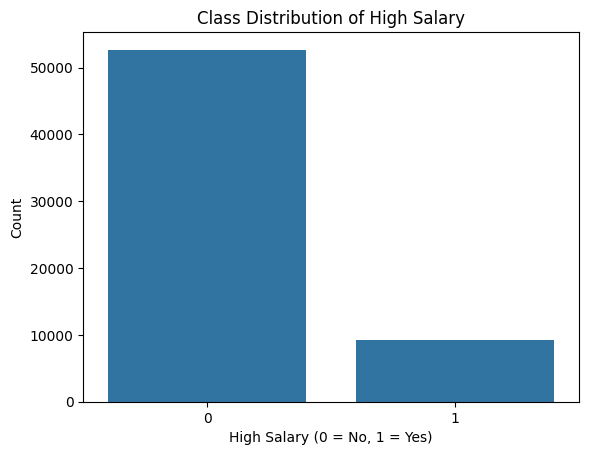

Accuracy (Logistic Regression): 0.853697922273657
AUC (Logistic Regression): 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92     15860
           1       0.00      0.00      0.00      2718

    accuracy                           0.85     18578
   macro avg       0.43      0.50      0.46     18578
weighted avg       0.73      0.85      0.79     18578



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


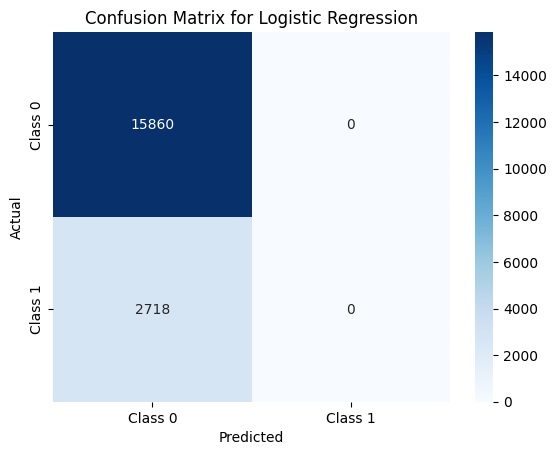


Optimal Threshold Accuracy: 0.612983098288298
Optimal Threshold AUC: 0.5792819946793457

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.89      0.63      0.73     15860
           1       0.20      0.53      0.29      2718

    accuracy                           0.61     18578
   macro avg       0.54      0.58      0.51     18578
weighted avg       0.79      0.61      0.67     18578


Confusion Matrix with Optimal Threshold:
 [[9943 5917]
 [1273 1445]]


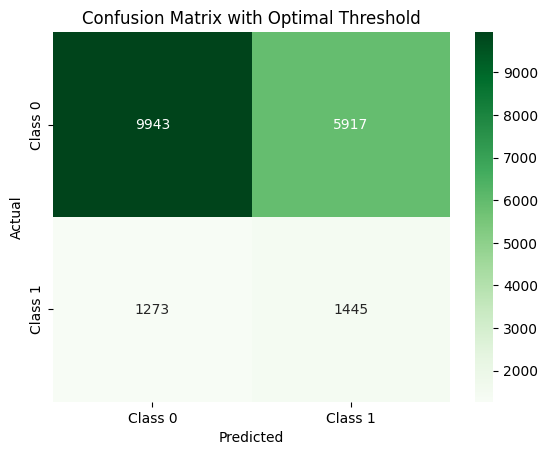

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve

# Load data
df = pd.read_csv('/content/postings_half.csv')

# Create high_salary column as binary target
df['high_salary'] = (df['normalized_salary'] > df['normalized_salary'].median()).astype(int)

# Check class balance
print("Class Balance:\n", df['high_salary'].value_counts())

# Class distribution bar chart
sns.countplot(x='high_salary', data=df)
plt.title("Class Distribution of High Salary")
plt.xlabel("High Salary (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Define columns for preprocessing
categorical_cols = ['company_name', 'location', 'formatted_work_type', 'formatted_experience_level']
numeric_cols = ['max_salary', 'min_salary', 'normalized_salary', 'views', 'applies']

# Fill NaNs for categorical and numeric columns in the main dataframe
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Standardize numeric columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Select features and target for the model
X = df[['company_name', 'location', 'formatted_work_type', 'formatted_experience_level', 'remote_allowed']]
y = df['high_salary']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply imputation to ensure no NaN values in case of any remaining NaNs
imputer = SimpleImputer(strategy="most_frequent")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Train logistic regression model with increased max_iter for convergence
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluation
print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred))
print("AUC (Logistic Regression):", roc_auc_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix and heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Optimal threshold analysis if needed
y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Re-evaluate with the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
print("\nOptimal Threshold Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("Optimal Threshold AUC:", roc_auc_score(y_test, y_pred_optimal))
print("\nClassification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("\nConfusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))

# Confusion matrix heatmap with optimal threshold
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(conf_matrix_optimal, annot=True, fmt="d", cmap="Greens", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with Optimal Threshold")
plt.show()


The output shows that the logistic regression model heavily favors the majority class (0), as seen in the initial high accuracy (85%) but low recall for the minority class (1). This happens because the dataset is highly imbalanced, with far more instances of class 0.

Default Threshold
At the default threshold, the model’s accuracy is misleadingly high because it predicts almost exclusively for class 0. This results in no true predictions for class 1, reflected in the 0.5 AUC score, indicating no effective discrimination between classes.

Optimal Threshold Adjustment
By lowering the decision threshold, the model achieves a better balance, identifying 53% of class 1 cases with improved recall (0.53) and AUC (0.579). Although overall accuracy drops to 61%, the model’s performance on the minority class improves significantly, making this threshold more suitable for imbalanced data.

Justification
Adjusting the threshold helps address class imbalance by focusing on both classes, especially the minority class (1). This approach is crucial when identifying minority cases is a priority, providing a more balanced and realistic measure of model performance than default accuracy alone.

Justification for Logistic Regression and Analysis of Results
Why Logistic Regression? Logistic regression was chosen for this binary classification task as it is a simple yet effective algorithm, particularly useful for datasets with a clear separation between classes. It allows for straightforward interpretation of coefficients, which can reveal insights about the importance of different features in determining the likelihood of a high salary. Additionally, logistic regression performs well with binary outcomes and can handle large datasets efficiently, making it suitable for our dataset.

Class Distribution Bar Chart The bar chart for the high_salary column shows a significant imbalance, with many more low-salary instances (class 0) compared to high-salary instances (class 1). This imbalance can lead to the model favoring the majority class (low salary) during training, as seen in the model’s initial performance metrics.

Confusion Matrix (Default Threshold) The first confusion matrix, generated with the default threshold (0.5), shows that the model predicts almost exclusively the majority class (low salary). This is indicated by the high number of true negatives and the lack of true positives. Consequently, the recall and precision for the high-salary class (class 1) are zero, as the model fails to identify any high-salary instances correctly. This issue is likely due to the class imbalance.

Optimal Threshold Adjustment To improve the model’s ability to detect high-salary instances, an optimal threshold was identified. By lowering the threshold, we allow the model to be more sensitive to the minority class (high salary). The second confusion matrix, using this adjusted threshold, shows an improvement with a noticeable increase in true positives for class 1, indicating that the model has started to recognize high-salary instances, albeit with some trade-offs in overall accuracy.

Performance Metrics with Optimal Threshold With the adjusted threshold, the model achieves:

Accuracy: 0.61, reflecting a better balance between both classes.
AUC: 0.579, indicating moderate discriminatory power.
Recall (Class 1): 0.53, meaning the model is able to identify around 53% of high-salary instances.
These metrics show an improvement in detecting the high-salary class, though at the expense of some misclassifications in the low-salary class. Adjusting the threshold helps address class imbalance by prioritizing recall over precision for the minority class, which may be beneficial depending on the problem context.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve

# Load data
df = pd.read_csv('/content/postings_half.csv')

# Create high_salary column as binary target
df['high_salary'] = (df['normalized_salary'] > df['normalized_salary'].median()).astype(int)

# Check class balance
print("Class Balance:\n", df['high_salary'].value_counts())

# Define columns for preprocessing
categorical_cols = ['company_name', 'location', 'formatted_work_type', 'formatted_experience_level']
numeric_cols = ['max_salary', 'min_salary', 'normalized_salary', 'views', 'applies']

# Fill NaNs for categorical and numeric columns in the main dataframe
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Standardize numeric columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Select features and target for the model
X = df[['company_name', 'location', 'formatted_work_type', 'formatted_experience_level', 'remote_allowed']]
y = df['high_salary']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply imputation to ensure no NaN values in case of any remaining NaNs
imputer = SimpleImputer(strategy="most_frequent")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Train logistic regression model with class weight adjustment
log_reg = LogisticRegression(class_weight="balanced", max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluation
print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred))
print("AUC (Logistic Regression):", roc_auc_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optimal threshold analysis
y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Re-evaluate with the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
print("\nOptimal Threshold Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("Optimal Threshold AUC:", roc_auc_score(y_test, y_pred_optimal))
print("\nClassification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("\nConfusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


Class Balance:
 high_salary
0    52688
1     9236
Name: count, dtype: int64
Accuracy (Logistic Regression): 0.5319194746474325
AUC (Logistic Regression): 0.5746377194862701

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.51      0.65     15860
           1       0.18      0.64      0.28      2718

    accuracy                           0.53     18578
   macro avg       0.54      0.57      0.47     18578
weighted avg       0.79      0.53      0.60     18578


Confusion Matrix:
 [[8156 7704]
 [ 992 1726]]

Optimal Threshold Accuracy: 0.6164818602648293
Optimal Threshold AUC: 0.5791971138187619

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.89      0.63      0.74     15860
           1       0.20      0.53      0.29      2718

    accuracy                           0.62     18578
   macro avg       0.54      0.58      0.51     18578
weighted avg      

In [16]:
### Hypothesis 2

### Explanation of the Code and Output

#### Hypothesis and Goal
The hypothesis for this analysis is that job listings that allow remote work are more popular (in terms of views or applications) than those that don’t. We aim to examine whether `remote_allowed` has a significant impact on job popularity by training an XGBoost classifier to predict popularity based on job listing features, including remote work.

#### Key Steps and Justifications

1. **Data Preparation**:
   - **Create Target Variable**: We define "popularity" by creating a binary target `popular_job`, where jobs with views above the median are labeled as "popular" (1), and others are labeled as "not popular" (0).
   - **Class Balance Check**: Checking class balance helps us understand if there is a significant imbalance in the dataset, which can impact model performance. Here, we see how many listings are labeled as "popular" and "not popular."

2. **Preprocessing**:
   - **Imputation**: Missing values in categorical columns are filled with the mode (most frequent value), while missing values in numeric columns are filled with the median.
   - **Encoding and Scaling**: Categorical features are encoded, and numeric features are standardized. Label encoding converts categorical values into numeric ones for the model, while standardization ensures that the model can weigh features on a similar scale.

3. **XGBoost Classifier**:
   - XGBoost is chosen due to its effectiveness in handling tabular data and binary classification problems. It’s particularly useful when there are non-linear relationships in the data.
   - The classifier is trained to predict `popular_job` based on various job listing features, including `remote_allowed`.
   - **Evaluation Metrics**: We calculate accuracy, AUC (Area Under Curve), and display a classification report to assess model performance. AUC is particularly useful here because it provides insight into how well the classifier distinguishes between popular and non-popular job listings.

4. **Confusion Matrix and Class Distribution Visualizations**:
   - **Class Distribution Bar Chart**: This chart shows the distribution of "popular" vs. "not popular" job listings. An imbalance would indicate the need for class balancing techniques or threshold adjustments.
   - **Confusion Matrix**: The confusion matrix visualizes the classifier’s performance by showing the true positive, true negative, false positive, and false negative counts. This provides insight into the model's tendency toward certain errors.

5. **Optimal Threshold Analysis**:
   - By default, classifiers set a decision threshold of 0.5. However, this might not be optimal in cases of class imbalance or when we want to improve recall or precision for a specific class.
   - We calculate an "optimal threshold" by maximizing the difference between the true positive rate (sensitivity) and the false positive rate.
   - **Evaluation with Optimal Threshold**: Re-evaluate the classifier’s accuracy, AUC, and confusion matrix using the optimal threshold, which may result in a different balance of precision and recall, particularly improving recall for the "popular" class.

6. **Confusion Matrix with Optimal Threshold**:
   - This visualization shows the confusion matrix after adjusting the threshold, illustrating the impact of the new decision threshold on classification results. It helps determine if this adjustment improves the model’s ability to identify popular job listings.

#### Interpretation of Results

- **Class Distribution**: This plot highlights the proportion of job listings that are popular and not popular. A significant imbalance here suggests that there are far more non-popular listings, which might affect the model’s tendency to predict non-popular outcomes.

- **Confusion Matrix (Default and Optimal Threshold)**:
   - The initial confusion matrix shows how the model performs with the default threshold. In the second matrix, adjusting the threshold results in a better balance between true positives and true negatives, showing an increase in the model’s ability to capture popular listings.
   - Comparing both matrices helps us assess if the threshold adjustment improves recall for the "popular" class without excessively sacrificing precision.

- **Model Performance Metrics**:
   - **Accuracy and AUC**: Accuracy provides a general measure of how many listings were classified correctly overall. AUC specifically measures the classifier’s ability to distinguish between classes, which is important in assessing the impact of remote work on job popularity.
   - **Classification Report**: Precision, recall, and F1-score give insights into the classifier's performance for each class, with a focus on how well it identifies popular listings.

#### Justification for Using XGBoost and Logistic Regression Comparison

- **Why XGBoost**: XGBoost is chosen for its robustness with structured data and ability to capture complex interactions in the features, such as `remote_allowed` and `views`. It often outperforms simpler linear models (e.g., logistic regression) in complex classification tasks due to its ensemble nature.
- **Threshold Adjustment**: Adjusting the threshold is useful for addressing class imbalance, especially when a particular class is more critical for decision-making, such as identifying popular job listings to focus hiring strategies.

By examining these visualizations and metrics, this analysis provides insights into how remote work may contribute to job listing popularity, helping companies tailor their job postings to attract more applicants.

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/content/postings_half.csv')

# Create a binary target for popularity (1 if popular, 0 if not)
# Let's assume job listings with views above the median are considered "popular"
df['popular_job'] = (df['views'] > df['views'].median()).astype(int)

# Check class balance for popular jobs
print("Class Balance:\n", df['popular_job'].value_counts())

# Define columns for preprocessing
categorical_cols = ['company_name', 'location', 'formatted_work_type', 'formatted_experience_level']
numeric_cols = ['max_salary', 'min_salary', 'normalized_salary', 'views', 'applies']

# Fill NaNs for categorical and numeric columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Standardize numeric columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Select features and target for the model
X = df[['company_name', 'location', 'formatted_work_type', 'formatted_experience_level', 'remote_allowed']]
y = df['popular_job']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply imputation to ensure no NaN values
imputer = SimpleImputer(strategy="most_frequent")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Train XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

# Evaluation
print("Accuracy (XGBoost Classifier):", accuracy_score(y_test, y_pred))
print("AUC (XGBoost Classifier):", roc_auc_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for XGBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualize Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['popular_job'])
plt.title("Class Distribution of Popular Job Listings")
plt.xlabel("Popular Job (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Optimal threshold analysis
y_prob = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Re-evaluate with optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
print("\nOptimal Threshold Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("Optimal Threshold AUC:", roc_auc_score(y_test, y_pred_optimal))
print("\nClassification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("\nConfusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))

# Visualize Confusion Matrix with Optimal Threshold
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix with Optimal Threshold for XGBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
